In [ ]:
fps = 20
dlc_folder = "deeplabcut_dir"
ex_id = "experiment_id"

In [ ]:
mouse_id = "mouse_id"
stim = 1
# visual oddball - 0
# visual angle   - 1
# elect hind paw - 2 

In [ ]:
save_dir = f"csv-dir/{mouse_id}/{ex_id}"

import os
os.mkdir(save_dir)

In [ ]:
import numpy as np
import pandas as pd
import os

folder_path = dlc_folder

columns_to_read = [x for x in range(33) if x % 3 != 0]

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

data_list = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path, usecols=columns_to_read, skiprows=2)
    data_list.append(df.to_numpy())

In [ ]:
data_list = data_list[1:]

row_counts = [arr.shape[0] for arr in data_list]
col_counts = [arr.shape[1] for arr in data_list]

min_rows = min(row_counts)
min_cols = min(col_counts)
trimmed_data_list = [arr[:min_rows, :min_cols].T for arr in data_list]

raw_data = np.stack(trimmed_data_list)

print(raw_data.shape)

In [ ]:
arr_4d_list = []
for i in range(raw_data.shape[0]):
    pairs = []
    for j in range(0, raw_data.shape[1], 2): 
        if j + 1 < raw_data.shape[1]: 
            pairs.append([raw_data[i, j], raw_data[i, j+1]])
    arr_4d_list.append(pairs)
arr_4d = np.array(arr_4d_list)

raw_pupil = arr_4d[:, 2:10]
print(raw_pupil.shape)

In [ ]:
import numpy as np

def process_array(arr):
    if arr.shape != raw_pupil.shape:
        raise ValueError(f"Input array must have shape {raw_pupil}")

    output_shape = (arr.shape[0], arr.shape[1] // 2, arr.shape[3])
    diameter_data = np.zeros(output_shape)

    for i in range(arr.shape[0]):
        for j in range(0, arr.shape[1], 2):
            for k in range(arr.shape[3]):
                diff = arr[i, j, :, k] - arr[i, j+1, :, k]
                squared_diff = diff ** 2
                sum_squared_diff = np.sum(squared_diff)
                sqrt_sum_squared_diff = np.sqrt(sum_squared_diff)
                diameter_data[i, j // 2, k] = sqrt_sum_squared_diff

    return diameter_data

diameter_data = process_array(raw_pupil)

print(diameter_data.shape)

(10, 4, 796)


In [ ]:
time = []
for i in range(diameter_data.shape[2]):
    value = i / fps
    time.append(value)

print(time[:7])  # first 7 frames
print(len(time))

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
796


(10, 796)


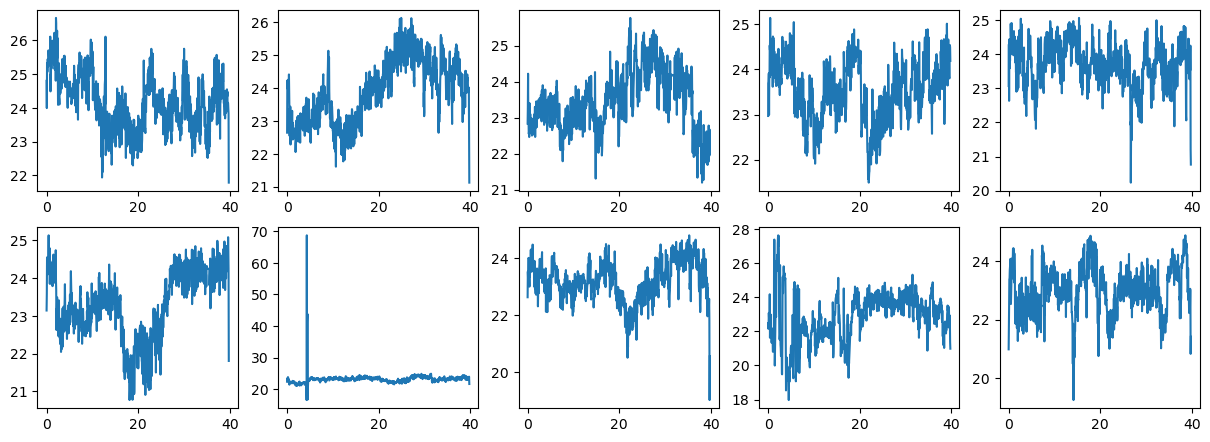

In [10]:
import matplotlib.pyplot as plt

# (top,bottom);0, (left,right);1, (tr,bl);2, (tl,br);3,  
use_diameter = diameter_data[:, 1]
print(use_diameter.shape)

plt.figure(figsize=(15,8))

for ex in range(use_diameter.shape[0]):
    plt.subplot(3, 5, ex+1)
    plt.plot(time, use_diameter[ex])

plt.show()

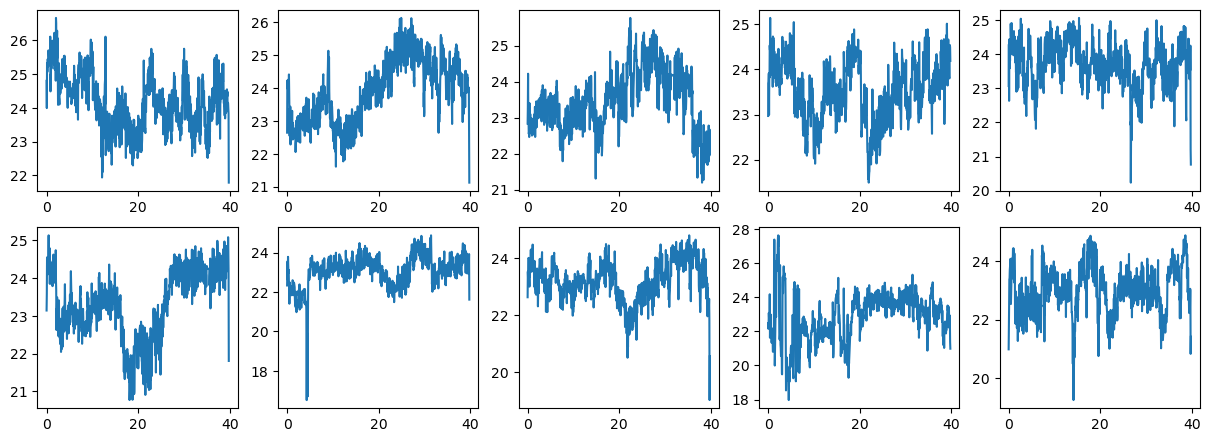

(10, 796)


In [ ]:
plt.figure(figsize=(15,8))

filtered_dm = []
for ex in range(use_diameter.shape[0]):
    temp_dm = use_diameter[ex].copy()

    n = len(use_diameter[ex])

    window_time = 0.5

    # range of sliding window
    window_size = int(fps*window_time)
    threshold = 0.3

    for i in range(1, n): 
        start = max(0, i - window_size + 1)
        end = i + 1
        
        window_median = np.median(temp_dm[start:end])

        if abs(temp_dm[i] - window_median) > threshold * window_median:
            temp_dm[i] = temp_dm[i - 1]
    plt.subplot(3, 5, ex+1)
    plt.plot(time, temp_dm)
    filtered_dm.append(temp_dm)
filtered_dm = np.array(filtered_dm)

plt.show()

print(filtered_dm.shape)

(10, 796)


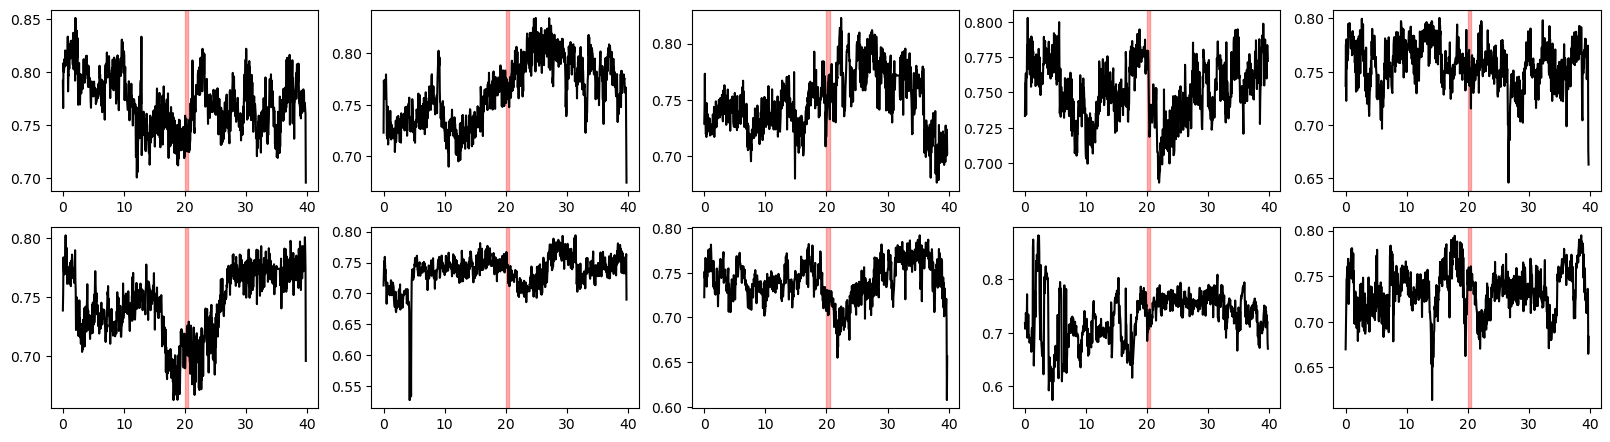

In [ ]:
resolution = 31.32  # pixel/mm

mm_diameter = filtered_dm / resolution
print(mm_diameter.shape)

plt.figure(figsize=(20,8))

for ex in range(mm_diameter.shape[0]):
    plt.subplot(3, 5, ex+1)
    plt.plot(time, mm_diameter[ex], color='black')
    if stim == 0:
        for set in range(16):
                plt.axvspan(set+0.5, set+1, color='black', alpha=0.3)
        for set in range(16, 40):
            plt.axvspan(set+0.5, set+1, color='blue', alpha=0.3)
        for dev in range(3):
            plt.axvspan(dev*8+21.5, dev*8+22, color='red', alpha=0.3) 
    if stim == 1:
        plt.axvspan(20, 30, color='red', alpha=0.3)
    if stim == 2:
        plt.axvspan(20, 20.5, color='red', alpha=0.3) 
        
plt.show()

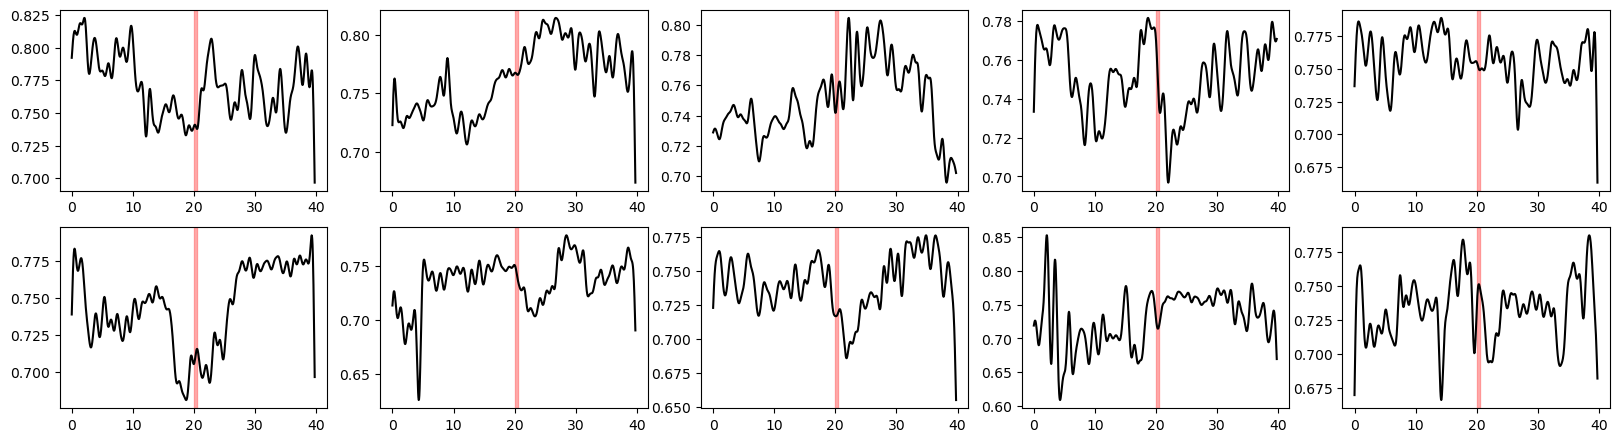

(10, 796)


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

cutoff = 1                      # cut-off frequency (Hz)
order = 4                        
nyquist = 0.5 * fps               
normal_cutoff = cutoff / nyquist  # normalized cut-off frequency



plt.figure(figsize=(20,8))

lowpass_dm = []
for ex in range(mm_diameter.shape[0]):
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    temp_lowpass = filtfilt(b, a, mm_diameter[ex])

    plt.subplot(3, 5, ex+1)
    plt.plot(time, temp_lowpass, color='black')
    if stim == 0:
        for set in range(16):
                plt.axvspan(set+0.5, set+1, color='black', alpha=0.3)
        for set in range(16, 40):
            plt.axvspan(set+0.5, set+1, color='blue', alpha=0.3)
        for dev in range(3):
            plt.axvspan(dev*8+21.5, dev*8+22, color='red', alpha=0.3) 
    if stim == 1:
        plt.axvspan(20, 30, color='red', alpha=0.3)
    if stim == 2:
        plt.axvspan(20, 20.5, color='red', alpha=0.3) 

    lowpass_dm.append(temp_lowpass)

lowpass_dm = np.array(lowpass_dm)

plt.show()

print(lowpass_dm.shape)

0.7746729444349779
0.7356988560803046
0.7358457736859109
0.7418292234742103
0.7655423122779643
0.7408789635085995
0.7408297007851874
0.7378142095462985
0.7001285190346179
0.7287695105205196


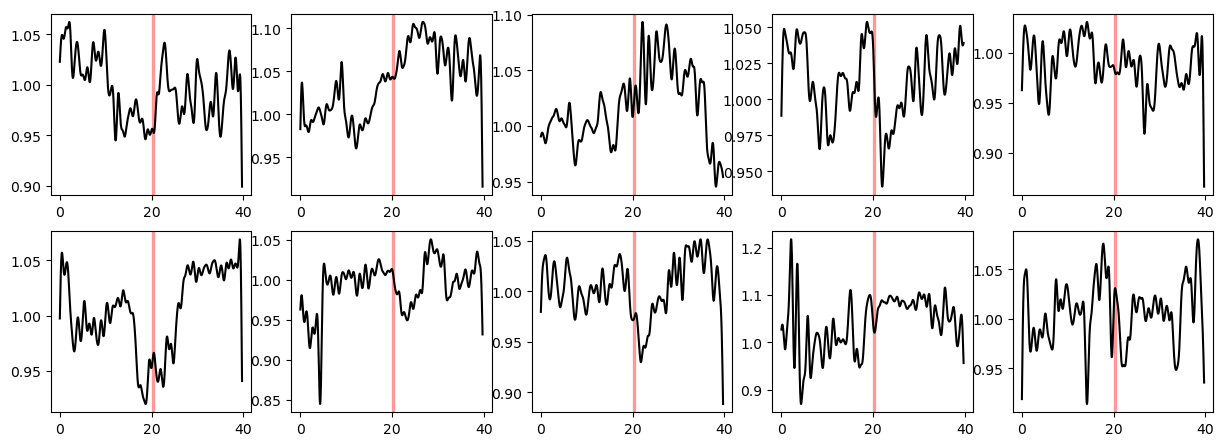

(10, 796)


In [15]:
start_baseline = 5 # second
end_baseline = 15

plt.figure(figsize=(15,8))

normalized_dm = []
for ex in range(mm_diameter.shape[0]):
    baseline_average = np.mean(lowpass_dm[ex, start_baseline*fps:end_baseline*fps])
    print(baseline_average)
    temp_norm = lowpass_dm[ex] / baseline_average
    plt.subplot(3, 5, ex+1)
    plt.plot(time, temp_norm, color='black')
    if stim == 0:
        for set in range(16):
                plt.axvspan(set+0.5, set+1, color='black', alpha=0.3)
        for set in range(16, 40):
            plt.axvspan(set+0.5, set+1, color='blue', alpha=0.3)
        for dev in range(3):
            plt.axvspan(dev*8+21.5, dev*8+22, color='red', alpha=0.3) 
    if stim == 1:
        plt.axvspan(20, 30, color='red', alpha=0.3)
    if stim == 2:
        plt.axvspan(20, 20.5, color='red', alpha=0.3) 
    normalized_dm.append(temp_norm)
normalized_dm = np.array(normalized_dm)

plt.show()

print(normalized_dm.shape)

0.7711337893280003 0.023280800384837708
0.7633748521782866 0.028999034391710886
0.7492113229782118 0.02414367053349497
0.7507856174998612 0.018578396717738924
0.7569639570308268 0.017609099836722812
0.7438701331428487 0.027267565855726192
0.7353759727221465 0.022974619698342084
0.7408238875930329 0.019934600937376225
0.7290841351007948 0.03912330132559605
0.7337555433208559 0.02209755161107931


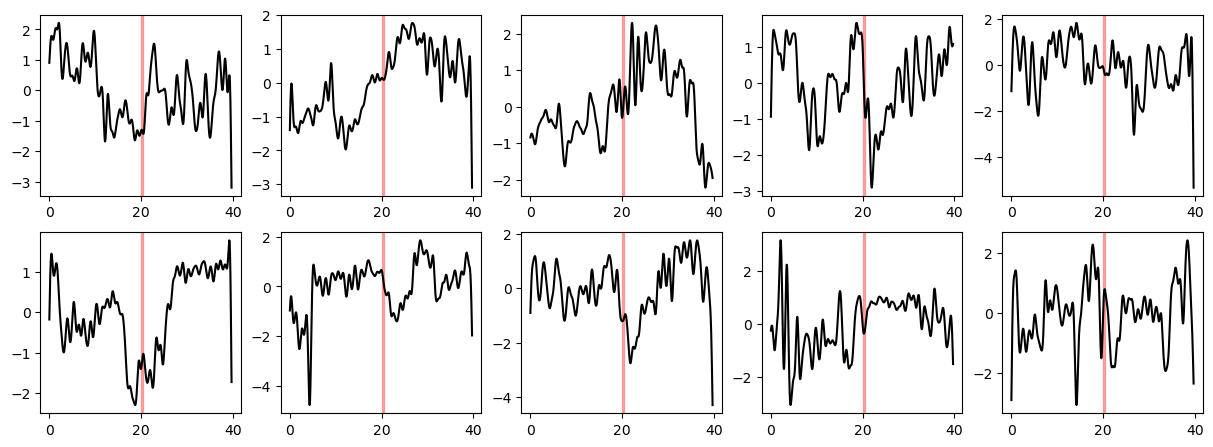

(10, 796)


In [16]:
plt.figure(figsize=(15,8))

Zscore_dm = []
for ex in range(mm_diameter.shape[0]):
    average = np.mean(lowpass_dm[ex])
    std = np.std(lowpass_dm[ex])
    print(average, std)
    temp_z = (lowpass_dm[ex] - average) / std
    plt.subplot(3, 5, ex+1)
    plt.plot(time, temp_z, color='black')
    if stim == 0:
        for set in range(16):
                plt.axvspan(set+0.5, set+1, color='black', alpha=0.3)
        for set in range(16, 40):
            plt.axvspan(set+0.5, set+1, color='blue', alpha=0.3)
        for dev in range(3):
            plt.axvspan(dev*8+21.5, dev*8+22, color='red', alpha=0.3) 
    if stim == 1:
        plt.axvspan(20, 30, color='red', alpha=0.3)
    if stim == 2:
        plt.axvspan(20, 20.5, color='red', alpha=0.3) 
    Zscore_dm.append(temp_z)
Zscore_dm = np.array(Zscore_dm)

plt.show()

print(Zscore_dm.shape)

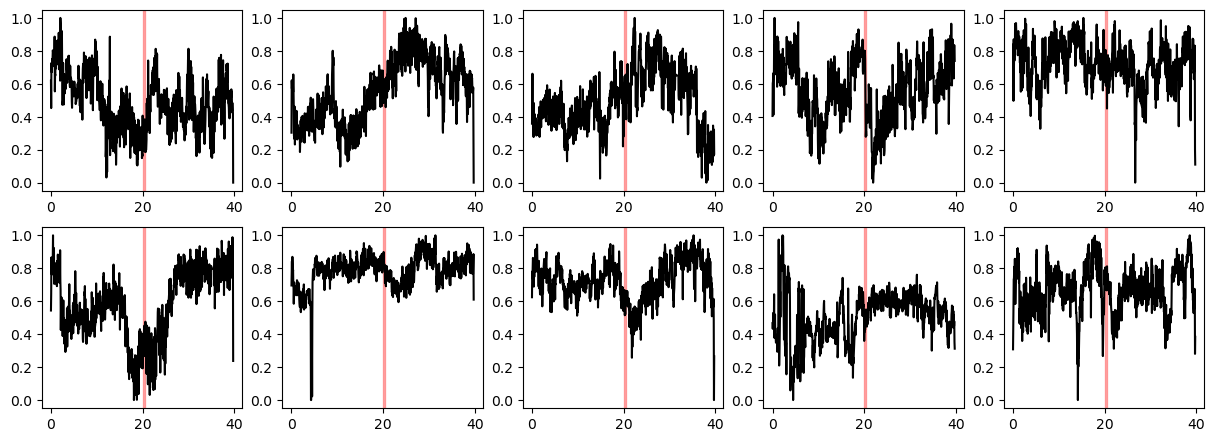

(10, 796)


In [ ]:
plt.figure(figsize=(15,8))

minimax_dm = []
for ex in range(mm_diameter.shape[0]):
    min_val = mm_diameter[ex].min()
    max_val = mm_diameter[ex].max()

    if max_val - min_val == 0:
        arr_norm = np.zeros_like(mm_diameter[ex])
    else:
        arr_norm = (mm_diameter[ex] - min_val) / (max_val - min_val)
    plt.subplot(3, 5, ex+1)
    plt.plot(time, arr_norm, color='black')
    if stim == 0:
        for set in range(16):
                plt.axvspan(set+0.5, set+1, color='black', alpha=0.3)
        for set in range(16, 40):
            plt.axvspan(set+0.5, set+1, color='blue', alpha=0.3)
        for dev in range(3):
            plt.axvspan(dev*8+21.5, dev*8+22, color='red', alpha=0.3) 
    if stim == 1:
        plt.axvspan(20, 30, color='red', alpha=0.3)
    if stim == 2:
        plt.axvspan(20, 20.5, color='red', alpha=0.3) 
    minimax_dm.append(arr_norm)
minimax_dm = np.array(minimax_dm)

plt.show()

print(minimax_dm.shape)

In [ ]:
start_sec = 5
end_sec   = 39


for ex in range(mm_diameter.shape[0]):
    np.save(f"{save_dir}/{ex_id}_ex0{ex}.npy", mm_diameter[ex, int(fps*start_sec):int(fps*end_sec)])